In [1]:
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from helper import *
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label


%matplotlib inline

C:\Program Files\Anaconda3\envs\CarND-Traffic-Sign-Classifier-Project_env\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Number of vehicle files: 8792
Number of non-vehicle files: 8968
Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


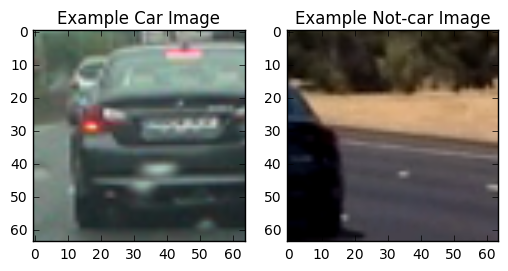

In [2]:
##Load the data
vehicle_files_dir = './vehicles/'
non_vehicle_files_dir = './non-vehicles/'
vehicle_files = extract_files(vehicle_files_dir)
non_vehicle_files = extract_files(non_vehicle_files_dir)

print('Number of vehicle files: {}'.format(len(vehicle_files)))
print('Number of non-vehicle files: {}'.format(len(non_vehicle_files)))

#Push images location to cars and not cars data structure
cars = []
notcars = []

for car in vehicle_files:
    cars.append(car)
for objs in non_vehicle_files:
    notcars.append(objs)

# Define a function to return some characteristics of the dataset 
data_info = data_look(cars, notcars)

print('Your function returned a count of',data_info["n_cars"], ' cars and',data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


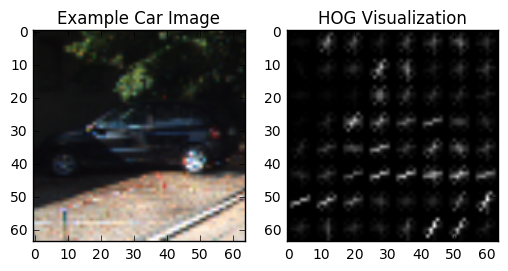

In [3]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


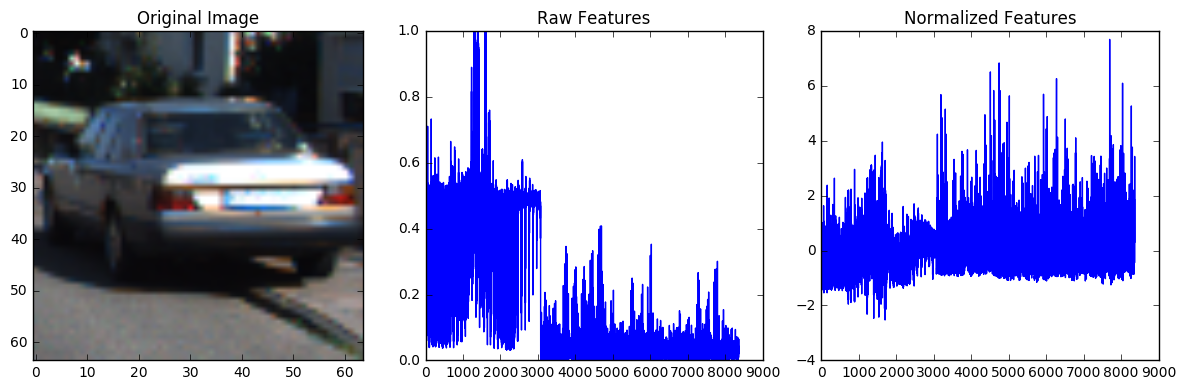

In [4]:
##Extract Features

### Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    

In [5]:
from sklearn.externals import joblib

svc = joblib.load('filename.pkl')

C:\Program Files\Anaconda3\envs\CarND-Traffic-Sign-Classifier-Project_env\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [6]:
y_start_stop = [490, 700] # Min and max in y to search in slide_window()

image = mpimg.imread('bbox-example-image.jpg')

draw_image = np.copy(image)
image = image.astype(np.float32)/255
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))

#1) Create an empty list to receive positive detection windows
on_windows = []
#2) Iterate over all windows in the list
for window in windows:
    #3) Extract the test window from original image
    test_img = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))  
        #4) Extract features for that window using single_img_features()
    features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        
    test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
    prediction = svc.predict(test_features)
        #7) If positive (prediction == 1) then save the window
    if prediction == 1 : 
        #if svc.decision_function(test_features) > 2500:
            on_windows.append(window)

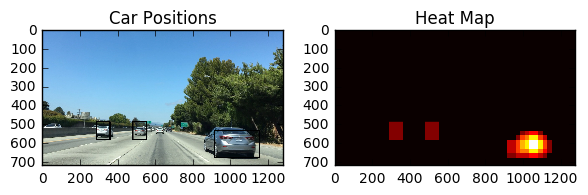

In [7]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,on_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [8]:
def car_detector(image):
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    y_start_stop = [400, 600] # Min and max in y to search in slide_window()
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))  
            #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
            #5) Scale extracted features to be fed to classifier
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
            #6) Predict using your classifier
        prediction = svc.predict(test_features)
            #7) If positive (prediction == 1) then save the window
        if prediction == 1 : 
#            if svc.decision_function(test_features) > 2000:
                on_windows.append(window)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,on_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(draw_image), labels)
    return draw_img

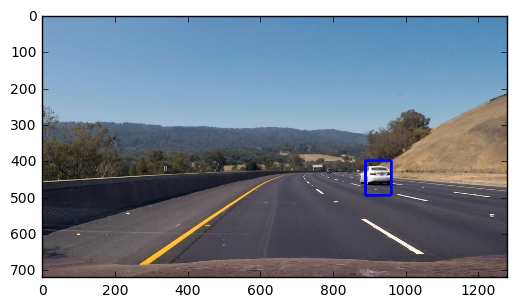

In [9]:
image = mpimg.imread('test_images/test3.jpg') 
detected = car_detector(image)
plt.imshow(detected)

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
project_output = 'project_test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4");
white_clip = clip1.fl_image(car_detector) 
%time white_clip.write_videofile(project_output, audio=False);

[MoviePy] >>>> Building video project_test_video_output.mp4
[MoviePy] Writing video project_test_video_output.mp4


 97%|████████████████████████████████████████▉ | 38/39 [05:12<00:08,  8.14s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_test_video_output.mp4 

Wall time: 5min 13s


In [12]:
project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4");
white_clip = clip1.fl_image(car_detector) 
%time white_clip.write_videofile(project_output, audio=False);

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|███████████████████████████████████▉| 1260/1261 [2:49:30<00:08,  8.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 2h 49min 32s
